In [3]:
import cv2
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

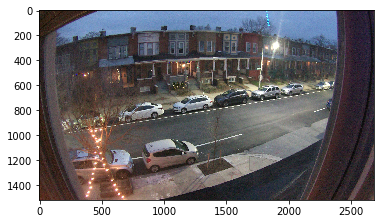

In [4]:
cal_path = "mounted-cars/calibration.jpg"
cal_color = cv2.flip(cv2.imread(cal_path), -1 ) #read & flip
plt.imshow(cv2.cvtColor(cal_color, cv2.COLOR_BGR2RGB))

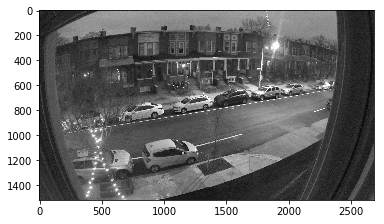

In [5]:
cal_path = "mounted-cars/calibration.jpg"
cal = cv2.flip(cv2.imread(cal_path, cv2.IMREAD_GRAYSCALE), -1 ) #read & flip
plt.imshow(cal, cmap='gray')

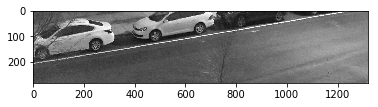

In [6]:
# crop to ROI
get_roi= lambda im: im[706:990, 680:2000]
cal_roi = get_roi(cal)
plt.imshow(cal_roi, cmap='gray')

In [7]:
import numpy as np
car_p1 = np.array([745, 881])
car_p2 = np.array([900, 856])
car_length_px = np.linalg.norm(car_p2 - car_p1)
px_2_m = lambda px: 1.93 * (px / car_length_px)
m_2_px = lambda m: (m / 1.93) * car_length_px
print("pixels per meter= {}".format(m_2_px(1)))
mps_2_mph = lambda mps: mps * 2.23694

pixels per meter= 81.34880035288904


In [74]:
import dateutil.parser

# for two frames
paths=[
    'mounted-cars/2018-12-27T17:07:10.167307.jpg',
    'mounted-cars/2018-12-27T17:07:10.792036.jpg',
]

# compare the time
def parse_time(path):
    time_s = path.split("mounted-cars/")[1][:-4]
    return dateutil.parser.parse(time_s)

t0 = parse_time(paths[0])
t1 = parse_time(paths[1])

def read_deep_image(path):
    im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return cv2.flip(im, -1) # flip

def read_roi(path):
    im = read_deep_image(path)
    return get_roi(im)

def subtract_bg(roi, cal):
    return roi - cal

TOO_HIGH = 180
def low_pass(no_bg):
    no_bg[no_bg > TOO_HIGH] = 0 # filter out too high values
    return no_bg

def read_roi_and_process(path, cal):
    roi = read_roi(path)
    no_bg = subtract_bg(roi, cal)
    return low_pass(no_bg)

# find the max value (maybe headlight?)
def get_max_in_roi(path, cal):
    roi = read_roi_and_process(path, cal)
#     print(np.argmax(roi))
#     print(np.unravel_index(np.argmax(roi), roi.shape))
    v_max = 0
    p = [-1, -1]
    for x in range(0, roi.shape[0]):
        for y in range(0, roi.shape[1]):
            v = roi[x, y]
            if v >= v_max:
                p = [x, y]
                v_max = v
    return (np.array(p), v_max)
#     r = np.max(np.argmax(roi, axis=0))
#     c = np.max(np.argmax(roi, axis=1))
#     return (np.array([r, c]), roi[r, c] )

delta_t = t1 - t0

# compute the distance
p0, v0 = get_max_in_roi(paths[0], cal_roi)
p1, v1 = get_max_in_roi(paths[1], cal_roi)

print(p0, v0) # these are wrong!!!
print(p1, v1) # need to draw on image

delta_p_pixels = np.linalg.norm(p1 - p0)
print("drove {}px in {} sec".format(delta_p_pixels, delta_t.total_seconds()))

delta_p_m = px_2_m(delta_p_pixels)
print("drove {}m in {} sec".format(delta_p_m, delta_t.total_seconds()))

speed_m = delta_p_m / delta_t.total_seconds()
print("car speed {} MPH".format(mps_2_mph(speed_m)))

[246 339] 180
[ 244 1016] 180
drove 677.0029542033033px in 0.624729 sec
drove 8.322224190971246m in 0.624729 sec
car speed 29.799026748800234 MPH


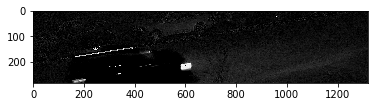

In [75]:
plt.imshow(read_roi_and_process(paths[0], cal_roi), cmap='gray')

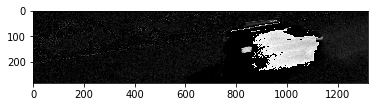

In [76]:
plt.imshow(read_roi_and_process(paths[1], cal_roi), cmap='gray')